# Introduction: Exploration of the 1000 Genomes Project data

The [1000 Genomes Project](https://www.nature.com/articles/nature15393) was an international research effort that aimed to create a comprehensive catalog of genetic variations in humans by sequencing more than 1000 human genomes. The project started in 2008 and completed its initial phase in 2015, involving the collaboration of over a thousand researchers from various institutions around the world.

The project focused on sequencing the genomes of individuals from various ethnic groups, including Africans, Asians, Europeans, and Americans. The goal was to identify differences in genomes -- such as single nucleotide polymorphisms (SNPs) and structural variations (SVs) -- that are shared by at least 1% in the population. The 1000 Genomes Project has been instrumental in advancing our understanding of human genetic variation and its impact on health and disease. The project's data set has been used in numerous studies to identify genetic risk factors for a wide range of diseases, including cancer, cardiovascular disease, and diabetes. The project's data is publicly available, allowing researchers worldwide to access and analyze the data to further advance our understanding of human genetics.

In this problem, we will use dimensionality reduction and clustering to explore the data from phase 3 of the project, which released data from over 2,500 individuals from 26 different populations around the world.

# Setting up the data
As in the previous problem, we first mount your Google Drive and import all the necessary libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt

Mounted at /content/drive


Now we import the data. There are two data files: `chr01-22_filtered.vcf` and `igsr_samples.tsv`. The two files can be downloaded from `COS343_Spring2023_Public/Homeworks/Datasets`. Once downloaded, you need to move the two files into your own Google Drive. Then, after executing `drive.mount('/content/drive')`, files in your Google Drive will be present in `/content/drive/MyDrive` and can be accessed by providing the path to them in your Drive.

Modify the paths of `snps_fn` and `origins` below to match the path to the two data files in your own Drive.

In [ ]:
# Data Import

# Load snp data from 1000 genomes project phase 3; this is a representative filtered subset of snps ~12k
snps_fn = "/content/drive/MyDrive/spring23/chr01-22_filtered.vcf"
data = pd.read_csv(snps_fn,
                   sep='\t', comment = "#",
                   index_col = False, header = None)

# Load column names for the snp data data 
with open(snps_fn, 'r') as f:
    meta = [l for l in f if l.startswith('#')]
    
data.columns = meta[len(meta)-1].split("\t")
data.columns.values[-1] = "NA21144" # reading in meta the last row includes a new line just easy way to reprocess it. 

# Load meta data; (it is a superset of all samples in data)
origins = pd.read_csv("/content/drive/MyDrive/spring23/igsr_samples.tsv",
                     sep = "\t")

# Examining the 1000 Genomes data
We first take a look at the `origins` variable, which contains the metadata of all the individuals sequenced in this dataset. Each row corresponds to an individual sequenced in the project, and contains metadata such as the sex, the superpopulation they come from, and the specific ethnic group (population) they come from.

In [ ]:
origins

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Data collections
0,HG00099,female,SAME123271,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
1,HG00096,male,SAME123268,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
2,HG00102,female,SAME123945,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
3,HG00104,female,SAME123950,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
4,HG00143,male,SAME124393,GBR,British,EUR,European,"1000 Genomes on GRCh38,1000 Genomes phase 3 re..."
...,...,...,...,...,...,...,...,...
3899,SC_GMWOF5428816,male,NaN,GWW,Gambian Wolof,AFR,African,Gambian Genome Variation Project
3900,SC_GMWOF5428873,female,NaN,GWW,Gambian Wolof,AFR,African,Gambian Genome Variation Project
3901,SC_GMMAN5482178,male,NaN,GWD,Gambian Mandinka,AFR,African,Gambian Genome Variation Project
3902,SC_GMMAN5482250,male,NaN,GWD,Gambian Mandinka,AFR,African,Gambian Genome Variation Project


Run the following cell to see that there are a total of five superpopulations: African, European, South Asian, East Asian, and American.

In [ ]:
origins['Superpopulation name'].value_counts()

African        1418
European        669
South Asian     661
East Asian      621
American        535
Name: Superpopulation name, dtype: int64

And there are a total of 29 specific ethnic groups (populations). The last three populations come from the Gambian Genome Variation Project and are actually not present in our actual sequencing data as we shall see shortly.

In [ ]:
origins['Population name'].value_counts()

Gambian Mandinka        280
Yoruba                  186
CEPH                    183
Esan                    173
Southern Han Chinese    171
Spanish                 162
Punjabi                 158
Puerto Rican            150
Colombian               148
Bengali                 144
Peruvian                130
Sri Lankan              128
Mende                   128
Kinh Vietnamese         124
African-Caribbean       123
Indian                  118
Luhya                   116
Gujarati                113
African-American SW     112
Han Chinese             112
Tuscan                  112
Dai Chinese             109
British                 107
Mexican-American        107
Japanese                105
Finnish                 105
Gambian Jola            100
Gambian Fula            100
Gambian Wolof           100
Name: Population name, dtype: int64

Now we look at the actual sequencing data from the 1000 Genomes Project. The `data` variable is a Pandas dataframe of size 12494 x 2513. Each row corresponds to a single nucleotide polymorphism (SNP) site in the human genome. That is, each row corresponds to a site in the human genome where two different nucleotides exist across the entire human population. For example, row 1 is position 1005806 in chromosome 1, and two nucleotides possibly exist at this position across the human populaiton: C and T. 

Each column after column 9 corresponds to an individual. For example, HG00096 is an individual who has C and C at position 1005806 in chromosome 1. Every individual has two nucleotides at a position in the genome because humans are diploid -- we each have a maternal and a paternal copy of the genome.

In [ ]:
print(data.shape) # supposed to be 12494; snps by human/samples
data.head()

(12494, 2513)


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,1,1005806,rs3934834,C,T,100,PASS,AA=C|||;AC=1119;AF=0.223442;AFR_AF=0.3941;AMR_...,GT,0|0,...,0|0,0|0,0|1,0|1,0|0,1|0,1|0,0|0,0|0,1|0
1,1,1079198,rs11260603,T,C,100,PASS,AA=c|||;AC=1520;AF=0.303514;AFR_AF=0.6271;AMR_...,GT,0|1,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0
2,1,1247494,rs12103,T,C,100,PASS,AA=T|||;AC=1599;AF=0.319289;AFR_AF=0.0923;AMR_...,GT,1|0,...,1|0,1|0,0|0,0|0,1|1,0|1,0|0,0|0,0|0,0|1
3,1,2069172,rs425277,C,T,100,PASS,AA=C|||;AC=1128;AF=0.22524;AFR_AF=0.0666;AMR_A...,GT,1|0,...,0|0,1|0,1|0,0|0,0|1,0|0,0|1,0|0,0|1,0|0
4,1,2069681,rs3753242,C,T,100,PASS,AA=C|||;AC=943;AF=0.188299;AFR_AF=0.0197;AMR_A...,GT,0|0,...,0|1,0|0,0|0,0|0,1|0,0|0,1|0,0|1,0|0,0|0


We now get rid of the first few columns of `data` and assign a new variable `snps`, so that `snps` is a Pandas dataframe where rows correspond to SNP sites and columns correspond to human individuals.

In [ ]:
snps = data.iloc[:,9:2513]
snps.head()

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00105,HG00106,HG00107,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,0|0,0|1,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|1,0|0,1|0,1|0,0|0,0|0,1|0
1,0|1,0|0,0|0,1|0,0|1,1|1,0|1,0|1,0|0,1|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0
2,1|0,1|1,1|1,1|1,1|1,1|1,0|1,1|1,1|1,0|1,...,1|0,1|0,0|0,0|0,1|1,0|1,0|0,0|0,0|0,0|1
3,1|0,0|0,1|0,1|0,0|0,0|1,0|0,0|1,0|0,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|1,0|0,0|1,0|0
4,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|0,0|0,0|0,1|0,0|0,1|0,0|1,0|0,0|0


At this point, each SNP site for each individual is represented by the notation **a|b**, where a and b are either 0 or 1. **0|0** means that the two copies of this individual's genome has the same nucleotide at this site, and the nucleotide is the same as the reference genome at this site. **1|0** or **0|1** means the two copies differ at this site, and one of them is a mutation. Similarly, **1|1** means the two copies are the same at this site, but both are mutations.

For our purpose, we just need to transform each of these mutation scenarios into discrete categorical states. After the transformation, each SNP site for each individual is represented by an integer state:

In [ ]:
snps = snps.apply(LabelEncoder().fit_transform, axis=1, result_type='broadcast')
snps.head()

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00105,HG00106,HG00107,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,0,1,0,2,0,0,0,0,0,0,...,0,0,1,1,0,2,2,0,0,2
1,1,0,0,2,1,3,1,1,0,2,...,0,0,0,0,0,0,0,0,1,0
2,2,3,3,3,3,3,1,3,3,1,...,2,2,0,0,3,1,0,0,0,1
3,2,0,2,2,0,1,0,1,0,1,...,0,2,2,0,1,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,0,2,1,0,0


`snps` is a dataframe with SNP sites as rows and individuals as columns. We take the transpoe of it so that rows are individuals and columns are SNP sites. Now we are ready to cluster the individuals according to their states at each SNP site.

`human_genomes` is our final processed data matrix of size 2504 x 12494. We have 2504 individuals in our final dataset, and for each individual we measured 12494 SNP sites.

In [ ]:
human_genomes_df = snps.T
human_genomes = human_genomes_df.to_numpy()
print(human_genomes.shape)

(2504, 12494)


Before clustering and dimensionality reduction, we first extract the population labels of each individual. `superpop_labels` is a 2504 x 1 vector recording the superpopulation of each individual in the dataset, and `pop_labels` is a 2504 x 1 vector recording the population/ethnic group of each individual in the dataset.

In [ ]:
superpop_label_dict = {key: value for key,value in zip(origins['Sample name'].values, origins['Superpopulation name'])}
superpop_labels = [superpop_label_dict[person] for person in snps.columns]

pop_label_dict = {key: value for key,value in zip(origins['Sample name'].values, origins['Population name'])}
pop_labels = [pop_label_dict[person] for person in snps.columns]

print(superpop_labels)
print(pop_labels)

['European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'European', 'Eu

## 1. Extract K-means labels

Use `sklearn.cluster.KMeans()` to cluster the individuals in `human_genomes` into five clusters and extract the cluster labels computed by K-means. Store the labels computed by K-means into `kmeans_labels`.

Compare the clusters computed by K-means with the ground truth superpopulation label `superpop_labels` above. To compare the similarity of two clusterings, use `sklearn.metrics.adjusted_rand_score()` (already imported). The documentation is at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html. Print out the ARI between the clusters computed by K-means and the ground truth superpopulation.

In [ ]:
kmeans_labels = None
# Cluster individuals in human_genomes into 5 clusters using KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(human_genomes)
kmeans_labels = kmeans.labels_

# Compute the adjusted rand score between k-means clusters and the ground truth superpopulation labels
ari = adjusted_rand_score(superpop_labels, kmeans_labels)
print("Adjusted Rand Score: {:.4f}".format(ari))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Score: 0.8734


## 2. Dimensionality reduction

Use `sklearn.decomposition.PCA()` (documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimensionality of each individual in `human_genomes` from 12494 to 10. Store the dimensionality reduced dataset into `human_genomes_PCA`.

In [ ]:
human_genomes_PCA = None
pca = PCA(n_components=10)
human_genomes_PCA = pca.fit_transform(human_genomes)
print(human_genomes_PCA.shape)

(2504, 10)


Use `sklearn.manifold.TSNE()` (documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the dimensionality of each individual in `human_genomes` from 12494 to 2. Store the dimensionality reduced dataset into `human_genomes_TSNE`.

In [ ]:
human_genomes_TSNE = None
human_genomes_TSNE = TSNE(n_components=2).fit_transform(human_genomes)
print(human_genomes_TSNE.shape)

(2504, 2)


Run the next two cells, which conveniently creates two Panda dataframes to store the results of PCA and TSNE respectively. Read the code to make sure you understand what it is doing.

In [ ]:
pca_df = pd.DataFrame(human_genomes_PCA)
pca_df.columns = ["PC_" + str(i) for i in range(1,human_genomes_PCA.shape[1]+1)]
pca_df["Superpopulation"] = superpop_labels
pca_df["Population"] = pop_labels
pca_df["kmean-labels"] = kmeans_labels
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,Superpopulation,Population,kmean-labels
0,-17.239799,-32.038139,3.844458,-7.124699,-3.006914,1.501219,2.867342,1.754378,6.427863,10.965600,European,British,4
1,-15.526824,-29.950161,5.098095,-10.605485,-2.548654,6.463758,5.596118,4.858252,1.236795,-3.275365,European,British,4
2,-16.059714,-30.659893,7.309971,-8.323017,-3.238365,-1.424197,2.437798,-3.283573,15.322347,-2.088010,European,British,4
3,-15.813091,-28.489648,6.248182,-8.511080,-3.722633,-7.059631,-7.138318,-1.992446,3.404647,7.821125,European,British,4
4,-15.567064,-28.263349,5.805480,-5.487714,3.390418,-0.999617,-5.605654,6.667084,-5.873140,6.458759,European,British,4


In [ ]:
tsne_df = pd.DataFrame(human_genomes_TSNE)
tsne_df.columns = ["TSNE_" + str(i) for i in range(1,human_genomes_TSNE.shape[1]+1)]
tsne_df["Superpopulation"] = superpop_labels
tsne_df["Population"] = pop_labels
tsne_df["kmean-labels"] = kmeans_labels
tsne_df.head()

,TSNE_1,TSNE_2,Superpopulation,Population,kmean-labels
0,-5.213494,-20.013414,European,British,4
1,-9.189895,-20.593037,European,British,4
2,-4.379083,-20.163223,European,British,4
3,-5.265850,-20.087612,European,British,4
4,-8.796184,-28.989595,European,British,4


## 3. Plotting PCA results

In this section, we will visualize the results of PCA and K-means.

Produce a 2D scatterplot of individuals, where the coordinates of each individual are the **first two principal components**. Color the individuals according to their **superpopulation**. Documentation of the scatterplot function can be found at https://seaborn.pydata.org/generated/seaborn.scatterplot.html.

<Axes: xlabel='PC_1', ylabel='PC_2'>

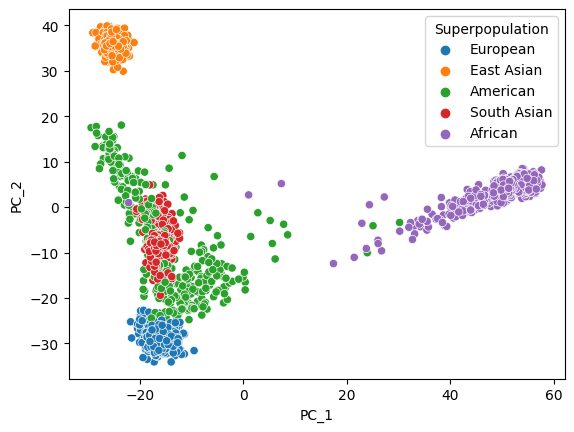

In [ ]:
sns.scatterplot(data=pca_df, x='PC_1', y='PC_2', hue='Superpopulation')

Produce a 2D scatterplot of individuals using the **first two principal components**, and color the individuals according to **the labels computed by the K-means algorithm**.

<Axes: xlabel='PC_1', ylabel='PC_2'>

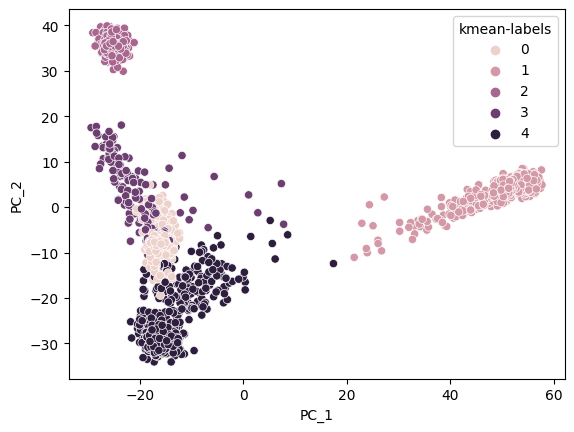

In [ ]:
sns.scatterplot(data=pca_df, x='PC_1', y='PC_2', hue='kmean-labels')

Produce a 2D scatterplot of individuals using the **first two principal components**, and color the individuals according to their **specific population**.

<Axes: xlabel='PC_1', ylabel='PC_2'>

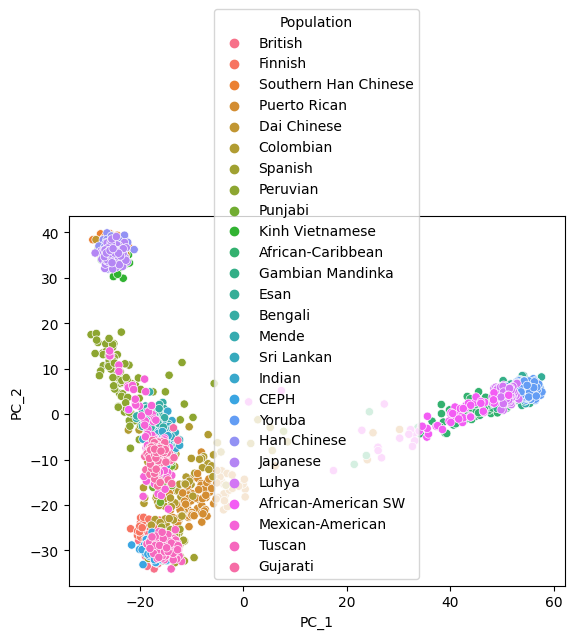

In [ ]:
sns.scatterplot(data=pca_df, x='PC_1', y='PC_2', hue='Population')

Produce a 2D scatterplot of individuals using **the second and the third principal components**, and color the individuals according to their **superpopulation**.

<Axes: xlabel='PC_2', ylabel='PC_3'>

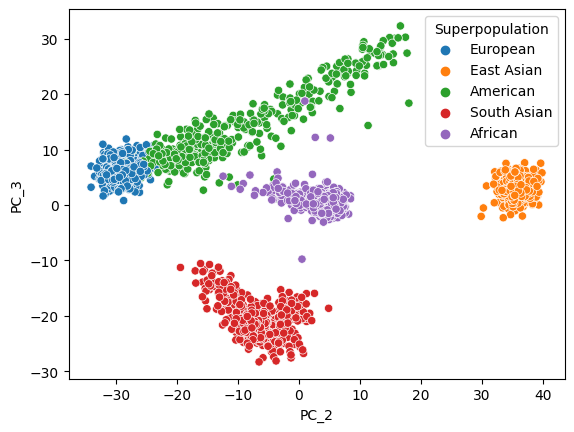

In [ ]:
sns.scatterplot(data=pca_df, x='PC_2', y='PC_3', hue='Superpopulation')

Produce a 2D scatterplot of individuals using **the second and the third principal components**, and color the individuals according to **the labels computed by the K-means algorithm**.

<Axes: xlabel='PC_2', ylabel='PC_3'>

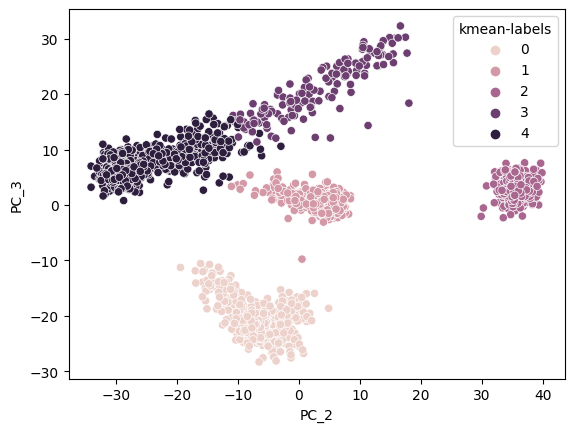

In [ ]:
sns.scatterplot(data=pca_df, x='PC_2', y='PC_3', hue='kmean-labels')

Produce a 2D scatterplot of individuals using **the second and the third principal components**, and color the individuals according to their **specific population**.

<Axes: xlabel='PC_2', ylabel='PC_3'>

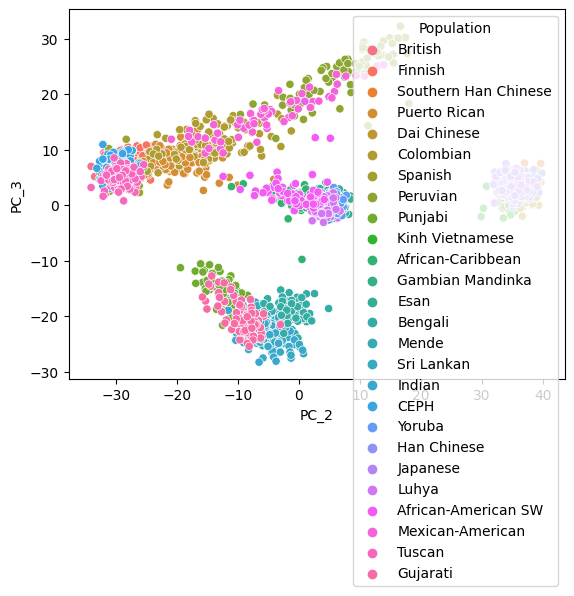

In [ ]:
sns.scatterplot(data=pca_df, x='PC_2', y='PC_3', hue='Population')

## 3. Plotting TSNE results

In this section, we will visualize the results of TSNE and K-means.

Produce a 2D scatterplot of individuals using the **TSNE results**, and color the individuals according to their **superpopulation**.

<Axes: xlabel='TSNE_1', ylabel='TSNE_2'>

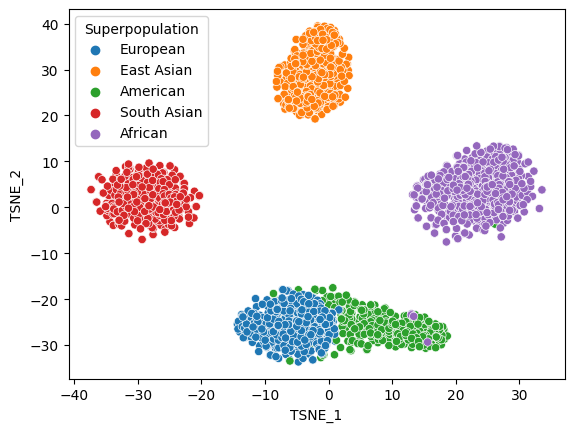

In [ ]:
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='Superpopulation')

Produce a 2D scatterplot of individuals using the **TSNE results**, and color the individuals according to **the labels computed by the K-means algorithm**.

<Axes: xlabel='TSNE_1', ylabel='TSNE_2'>

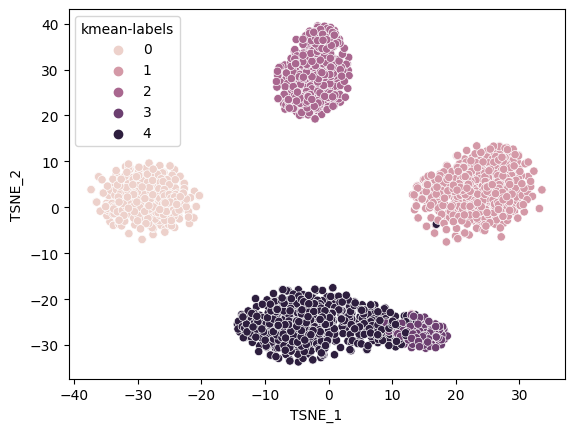

In [ ]:
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='kmean-labels')

Produce a 2D scatterplot of individuals using the **TSNE results**, and color the individuals according to their **specific population**.

<Axes: xlabel='TSNE_1', ylabel='TSNE_2'>

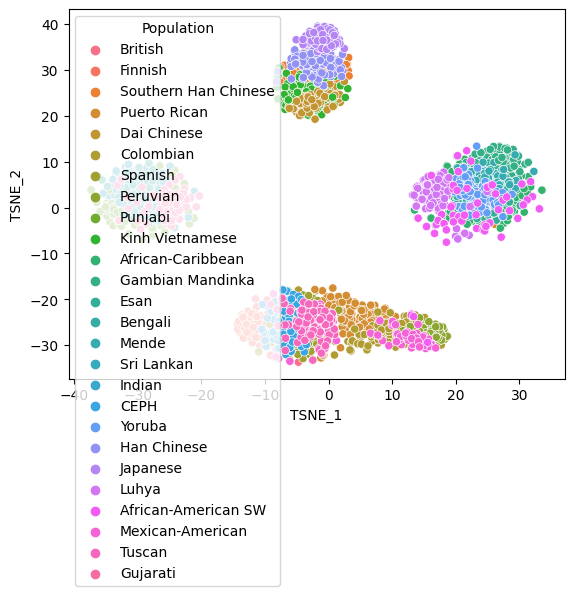

In [ ]:
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='Population')